In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Reading the data

In [2]:
train=pd.read_csv('/kaggle/input/titanic/train.csv')
test=pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


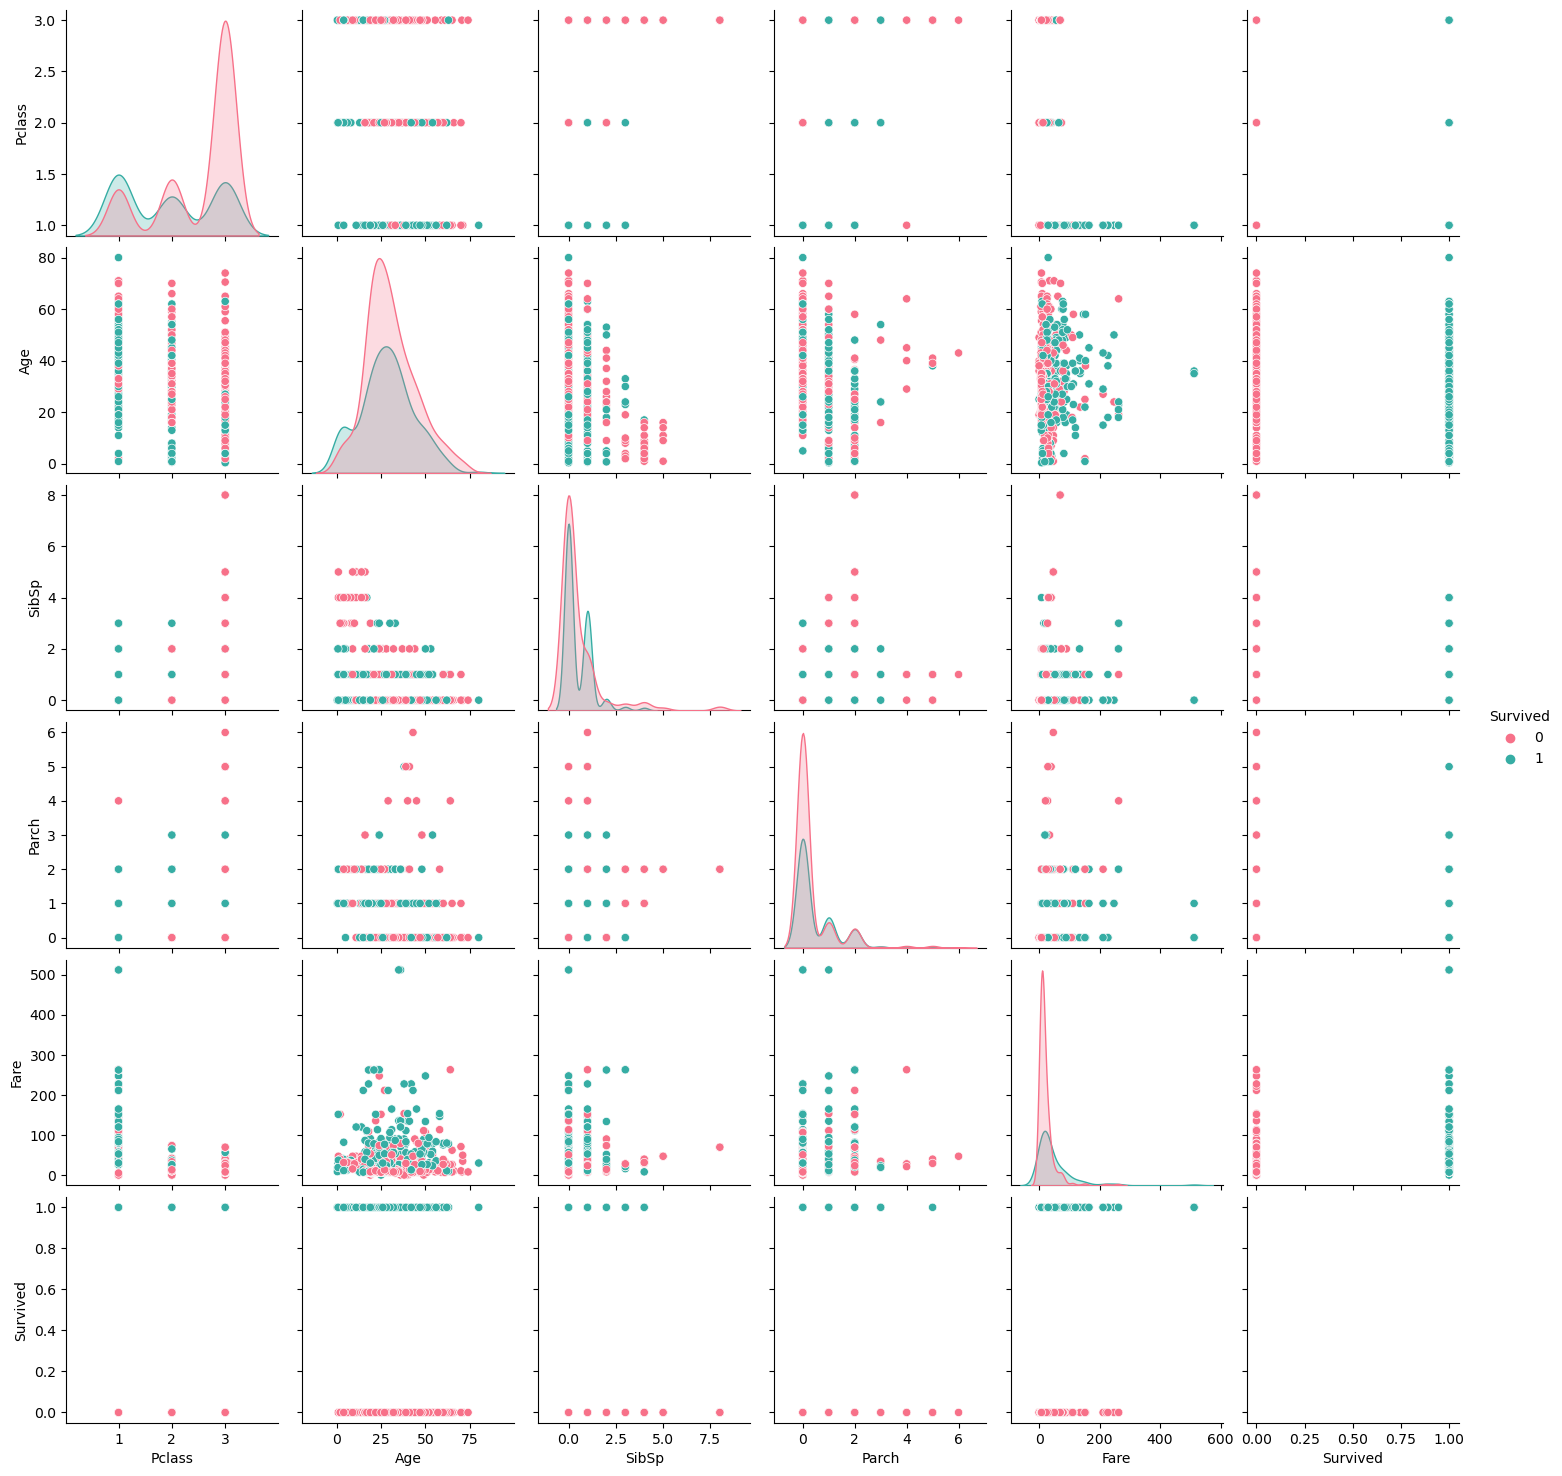

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare','Survived']
sns.pairplot(train, vars=cols, hue='Survived', palette='husl', diag_kind='kde')
plt.show()

In [5]:
rows_with_null =train.isnull().sum()
print(rows_with_null)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [6]:
rows_with_null =test.isnull().sum()
print(rows_with_null)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [12]:
train=pd.read_csv('/kaggle/input/titanic/train.csv')
test=pd.read_csv('/kaggle/input/titanic/test.csv')

In [13]:
def fill_data(data):
    #dropping Name and Cabin cols and name is not required and Cabin has more then 50% missing values
    data=data.drop(['Name','Cabin',],axis=1)
    #filling the following missing values with median value
    cols=['Age','Fare']
    for col in cols:
        data[col].fillna(data[col].median(),inplace=True)
    #filling embarked values with S as that was majority
    data["Embarked"] = data["Embarked"].fillna("S")
    #using the following to make the fare distribution into normal distribution
    data["Fare"] = data["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
    return data

test=fill_data(test)
train=fill_data(train)


In [14]:
train_X=train.drop(['Survived','PassengerId','Ticket'],axis=1)
train_y=train['Survived']

In [15]:
test=test.drop(['PassengerId','Ticket'],axis=1)

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
selected_features = ['Fare', 'Age']
def scaling_train(data):
    data_to_scale = data[selected_features]
    scaled_data = scaler.fit_transform(data_to_scale)
    data[selected_features] = scaled_data
    return data

def scaling_test(data):
    data_to_scale = data[selected_features]
    scaled_data = scaler.transform(data_to_scale)
    data[selected_features] = scaled_data
    return data
train_X=scaling_train(train_X)
test=scaling_test(test)

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
def encoding_train(data):
    data['Pclass'] = label_encoder.fit_transform(data['Pclass'])
    data = pd.get_dummies(data, columns=['Sex', 'Embarked'])
    return data
def encoding_test(data):
    data['Pclass'] = label_encoder.transform(data['Pclass'])
    data = pd.get_dummies(data, columns=['Sex', 'Embarked'])
    return data
train_X=encoding_train(train_X)
test=encoding_test(test)

In [18]:
test2=pd.read_csv('/kaggle/input/titanic/test.csv')
ids=test2['PassengerId']

In [22]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

#individual classifiers
cat = CatBoostClassifier(iterations=2000, learning_rate=0.01, depth=6, verbose=0, eval_metric='Accuracy')
ada = AdaBoostClassifier(n_estimators=1000)  
rf = RandomForestClassifier(n_estimators=1000, max_depth=8)
et = ExtraTreesClassifier(n_estimators=1000, max_depth=8)
gb = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth=6)

#ensemble voting classifier
ensemble = VotingClassifier(
    estimators=[('cat', cat), ('ada', ada), ('rf', rf), ('et', et), ('gb', gb)],
    voting='hard' 
)

ensemble.fit(train_X, train_y)
pred_y = ensemble.predict(test)

output_df = pd.DataFrame({'PassengerId': ids, 'Survived': pred_y})
output_df.to_csv('outputEnsemble003.csv', index=False)
